In [2]:
#generic imports

import cv2
import os 
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#tensorflow imports

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Layer, Input, Flatten
import tensorflow as tf

In [4]:
#gpu optimisation

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    pass
#tf.config.experimental.set_memory_growth(gpu, True)

[]


In [5]:
# making folders to store the images

NEG_PATH=os.path.join('data','neg')  #data//neg
POS_PATH=os.path.join('data','pos')  #data//pos
ANC_PATH=os.path.join('data','anc')  #data//anc

os.makedirs(NEG_PATH)
os.makedirs(POS_PATH)
os.makedirs(ANC_PATH)

In [21]:
# taking out the data into the 'lfw' folder from the tar file
!tar -xf lfw.tgz

In [23]:
#smartly shifting the files from inside the repos of lfw into the negatives folder (keeping the file name intact)

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        OLD_PATH=os.path.join('lfw',directory,file)
        NEW_PATH=os.path.join(NEG_PATH,file)
        os.replace(OLD_PATH,NEW_PATH)

In [7]:
import uuid
print(uuid.uuid1())

16d8159d-26fb-11ee-9165-a7c480a70e41


In [10]:
#code to capture photos from webcam to make up the anchor and the positives folders

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    face=frame[50:50+250,120:120+250,:] #2 reasons (all images in the negative were 250x250, and these pixels were also were my face lied majorly)
    

    cv2.imshow('Image collection',frame) # maintain live replay of the frame
    
    #on pressing 'a', to save the frame into the anchor folder with a unique name
    if cv2.waitKey(1) & 0xFF == ord('a'):
        filePath=os.path.join(ANC_PATH,f"{uuid.uuid1()}.jpg")
        cv2.imwrite(filePath,face)
    
    #on pressing 'p', to save the frame into the positives folder again with a unique name
    if cv2.waitKey(1) & 0xFF == ord('p'):
        filePath=os.path.join(POS_PATH,f"{uuid.uuid1()}.jpg")
        cv2.imwrite(filePath,face)
        
    #to quit from the frame
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

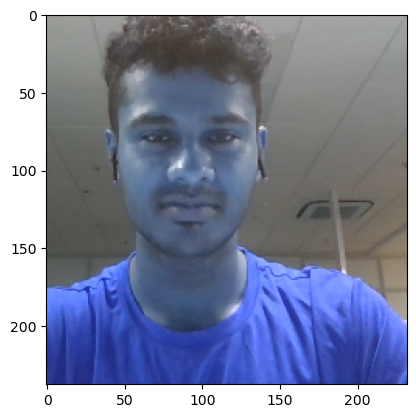

In [11]:
#example of the last image captured
plt.imshow(frame[50:50+250,120:120+250,:])

In [24]:
#making a type of data loader, but only for the file names (taking 300 as a batch (same number))
anchor=tf.data.Dataset.list_files(f"{ANC_PATH}\*.jpg").take(300)
positive=tf.data.Dataset.list_files(f"{POS_PATH}\*.jpg").take(300)
negative=tf.data.Dataset.list_files(f"{NEG_PATH}\*.jpg").take(300)

In [25]:
#example of how to use the loader
load=anchor.as_numpy_iterator()
print(load.next())


b'data\\anc\\5e8d705d-26fb-11ee-abd1-a7c480a70e41.jpg'


In [27]:
#function to preprocess and return the image as a tensor of pixel values scaled from (0,1) and resized to 100,100
#the array is returned on passing in just the file name

def preprocess(file_path):
    
    #2 lines of code to read in from the file path and create the array
    img_byte=tf.io.read_file(file_path)
    img=tf.io.decode_jpeg(img_byte)
    
    img=tf.image.resize(img,(100,100))
    img=img/255
    
    return img
   
preprocess('data\\anc\\5e8d705d-26fb-11ee-abd1-a7c480a70e41.jpg')

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.6051372 , 0.6247451 , 0.6090588 ],
        [0.6090588 , 0.62866664, 0.61298037],
        [0.6117647 , 0.6313726 , 0.6156863 ],
        ...,
        [0.6467333 , 0.6663411 , 0.6428117 ],
        [0.6403287 , 0.65993655, 0.63640714],
        [0.6433937 , 0.66300154, 0.6394721 ]],

       [[0.59866667, 0.6182745 , 0.60258824],
        [0.6038431 , 0.62345093, 0.60776466],
        [0.6075686 , 0.62717646, 0.6114902 ],
        ...,
        [0.63957256, 0.65835685, 0.635102  ],
        [0.64010113, 0.6588855 , 0.63563055],
        [0.6162205 , 0.6350048 , 0.6117499 ]],

       [[0.59607846, 0.6156863 , 0.6       ],
        [0.5982353 , 0.61784315, 0.6021569 ],
        [0.59705883, 0.6166667 , 0.6009804 ],
        ...,
        [0.64431375, 0.6521569 , 0.63254905],
        [0.64130217, 0.6491453 , 0.62953746],
        [0.5968392 , 0.6046823 , 0.5850745 ]],

       ...,

       [[0.5887962 , 0.21232568, 0.14958058],
        [0.58

In [28]:
#goal here is to make another data loader, which returns an array, 1st item being the input (anchor image)'s file name,
#2nd be the validation (positive's or negative's) file name, and finally the score (0 for negative, 1 for positive)

#creating a dataset (positive samples) of such a format using only the positives first
#the line tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor))) -> creates a data loader similar ot anchor, and positive
#so that only the same type of data is passed into the .zip function
positives=tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))

# same trip for the negatives samples
negatives=tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

#concatenate the entire dataset with the positive and negative samples
data=positives.concatenate(negatives)
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [29]:
loader=data.as_numpy_iterator()
example=loader.next()

In [30]:
def preprocess_entry(input_img,valid_img,score):
    return (preprocess(input_img),preprocess(valid_img),score)

res=preprocess_entry(*example)


In [31]:
data=data.map(preprocess_entry)
data=data.cache()
data=data.shuffle(buffer_size=1024)

In [32]:
training_data=data.take(round(len(data)*0.7))
training_data=training_data.batch(16)  #makes a batch of 16
training_data=training_data.prefetch(8)  # check optimisation notes for pre-fetch

In [33]:
test_data=data.skip(round(len(data)*0.7))   #taking the remaining 30% into the test data
test_data=test_data.take(round(len(data)*0.3))
test_data=test_data.batch(16)
test_data=test_data.prefetch(8)

In [34]:
example=test_data.as_numpy_iterator()
res=example.next()
res[2][0]

1.0

In [35]:
#model from https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf

inp=Input(shape=(100,100,3),name='input layer')
c1=Conv2D(64,(10,10),activation='relu')(inp)  #(kernels,kernel shape)
m1=MaxPool2D(64,(2,2),padding='same')(c1)   #now what padding='same' does is keeps enough padding to make the input and output of the
#same shape [hence only the conv which affetcs the input and output shape]

c2=Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPool2D(64,(2,2),padding='same')(c2)

c3=Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPool2D(64,(2,2),padding='same')(c3)

c4=Conv2D(256,(4,4),activation='relu')(m3)
f=Flatten()(c4)
d1=Dense(4096,activation='sigmoid')(f)

mod=Model(inputs=[inp],outputs=[d1],name='embedding')
mod.summary()


Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [36]:
#making the function to make the embeddings from the input image according to the architecture of the paper

def make_embeddings():
    inp=Input(shape=(100,100,3),name='input layer')
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPool2D(64,(2,2),padding='same')(c1)

    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPool2D(64,(2,2),padding='same')(c2)

    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPool2D(64,(2,2),padding='same')(c3)

    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f=Flatten()(c4)
    d1=Dense(4096)(f)
    
    return Model(inputs=[inp],outputs=[d1],name='embeddings')

embedding=make_embeddings() #now we'll just call this function inside the siamese_network function 
embedding.summary()

Model: "embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       2

In [37]:
#now the instance of this class will have a call default function which returns the distance of the 2 embeddings passed in 
#now why not make a function like the others -> strong intuition is that cos we have to make use of the Layer class in the init

class L1Dist(Layer):
    
    #mandatory
    def __init__(self,**kwargs):
        super().__init__() #now why we do this is because we would want the class instance to share a few properties of the Layer super class
        #so taking it in the init step
    
    #real deal -> so the thing with call() function is that we dont need to mention it while calling it, just make an instance
    # and then pass it into the instance
    def call(self,input_embeddings,validation_embeddings):
        return tf.math.abs(input_embeddings-validation_embeddings)



In [38]:
def make_siamese():
    
    image_input=Input(shape=(100,100,3),name='INPUT IMAGE')
    image_validation=Input(shape=(100,100,3),name='VALIDATION IMAGE')
    
    l1layer=L1Dist()
    
    #this is where the call function just worked
    distances=l1layer(embedding(image_input),embedding(image_validation))
    
    classifier=Dense(1,activation='sigmoid')(distances)
    
    return Model(inputs=[image_input,image_validation],outputs=classifier,name='siamese_network') 
    #had an error here for naming the network as 'siamese network', didnt fit some rule



In [39]:
#making an instance of the model to use later
siamese_model=make_siamese()
siamese_model.summary()

Model: "siamese_network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 INPUT IMAGE (InputLayer)       [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 VALIDATION IMAGE (InputLayer)  [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embeddings (Functional)        (None, 4096)         38960448    ['INPUT IMAGE[0][0]',            
                                                                  'VALIDATION IMAGE[

In [40]:
#defining the loss and optimisers for using in the custom train function
binary_loss=tf.losses.BinaryCrossentropy()
opt=tf.keras.optimizers.Adam(1e-4)

#checkpoint constants 1) checkpoint_prefix - location to store the checkpoints in after a set number of epochs
#checkpoint instance, which takes in the prefix while .save()

checkpoint_dir='./checkpoint'
checkpoint_prefix=os.path.join(checkpoint_dir,'ckpt')
checkpoint=tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [41]:
#so heres the custom train function, it is quite different than just wrapping it inside the model, and there is full control over
#the training process. So here we'd have to pass in the model, the training data, loss functions and optimizers.

#MAKING THE FUNCTION WHICH TRAINS PER BATCH

@tf.function #this decorator compiles the following code into a TensorFlow graph
def train_batch(batch):
    
    #so tf.GradientTape creates a context manager, which tracks all the operations inside the block, and then calculate the
    #gradients outside of it
    with tf.GradientTape() as tape:
        
        #The X would be both the input image and the validation image
        X=batch[:2]
        #the y would be the score (1->positive samples and 0 ->negative samples)
        y=batch[2]
        
        #finding the loss for the whole batch
        yhat=siamese_model(X,training=True)  #mentioning training here is actually imp
        loss=binary_loss(y,yhat)
        
    print(loss) #not sure if this would have worked
    
    #so in this tape.gradient function, we'd have to pass the loss to be differentiated on, and the variables wrt to which it should
    grad=tape.gradient(loss,siamese_model.trainable_variables)
    #and then apply these gradients to the optimizer
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss




In [42]:
#now make the function which takes in the training data and no of epochs, and then for each epoch passes the batches into
#the train_batch function, and in the process also shows the progress bar about the progressbar

def train(data,EPOCHS):
    for epoch in range(1,EPOCHS+1):
        print(f'{epoch}/{EPOCHS}')
        
        #making a new progbar for every epoch
        progbar=tf.keras.utils.Progbar(len(data))
        
        
        for idx, batch in enumerate(data):
            train_batch(batch) #train each batch
            progbar.update(idx+1) #update the progbar
        
        if epoch % 10==0:
            checkpoint.save(file_prefix=checkpoint_prefix) #saving the checkpoint after every 10 epochs

In [43]:
train(training_data,30)

1/30
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
23/23 [==============================] - 634s 27s/step
2/30
23/23 [==============================] - 619s 27s/step
3/30
23/23 [==============================] - 627s 27s/step
4/30
23/23 [==============================] - 666s 29s/step
5/30
23/23 [==============================] - 691s 30s/step
6/30
23/23 [==============================] - 632s 27s/step
7/30
23/23 [==============================] - 598s 26s/step
8/30
23/23 [==============================] - 498s 22s/step
9/30
23/23 [==============================] - 499s 22s/step
10/30
23/23 [==============================] - 578s 25s/step
11/30
23/23 [==============================] - 545s 24s/step
12/30
23/23 [==============================] - 510s 22s/step
13/30
23/23 [==============================] - 503s 22s/step
14/30
23/23 [==============================] - 560s 24s/step
1

In [44]:
from tensorflow.keras.metrics import Precision, Recall

test_input,test_valid,y_true=test_data.as_numpy_iterator().next()

y_pred=siamese_model.predict([test_input,test_valid])



1/1 [==============================] - 3s 3s/step


In [45]:
y_pred=[1 if prediction > 0.5 else 0 for prediction in y_pred]
y_pred


[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]

In [46]:
y_true

array([0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [47]:
m=Recall()   # could also go for m=Precision()
m.update_state(y_true,y_pred)
m.result().numpy()

1.0

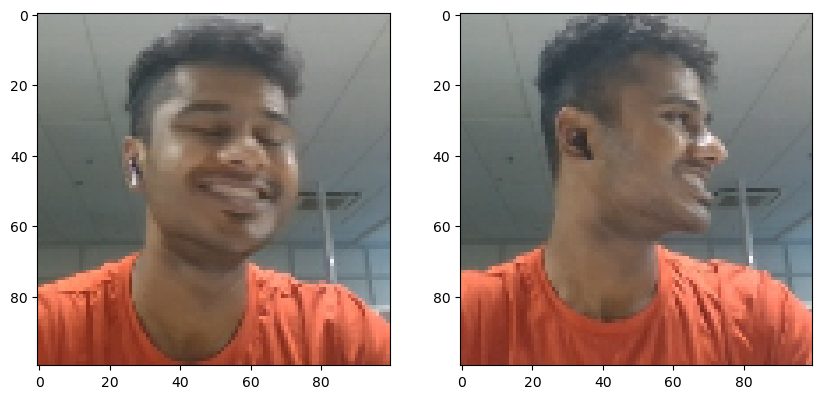

In [48]:
#now to also just go ahead and visualise it once (kinda see of matplotlib works)

plt.figure(figsize=(10,8))

#input image
plt.subplot(1,2,1)
plt.imshow(test_input[2]) #just change the index to go to a different image inside the same batch

#validation image
plt.subplot(1,2,2)
plt.imshow(test_valid[2])

#to render it cleanly
plt.show()

In [49]:
#save the model

siamese_model.save('siamesemodel.h5')

In [50]:
model=tf.keras.models.load_model('siamesemodel.h5',custom_objects={'L1Dist':L1Dist})

In [51]:
[1 if prediction>0.5 else 0 for prediction in model.predict([test_input,test_valid])]

1/1 [==============================] - 1s 1s/step


[0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0]

In [52]:
validation_img_path=os.path.join('application_data','validation_images')
input_path=os.path.join('application_data','input_image','input_image.jpg')

files=os.listdir(validation_img_path)
print(len(files))
for file in files:
    print(os.path.join(validation_img_path,file))


31
application_data\validation_images\.ipynb_checkpoints
application_data\validation_images\b11f772d-26fb-11ee-a66d-a7c480a70e41.jpg
application_data\validation_images\b19970c4-26fb-11ee-ab5a-a7c480a70e41.jpg
application_data\validation_images\b31a4507-26fb-11ee-bf44-a7c480a70e41.jpg
application_data\validation_images\b3a96c1c-26fb-11ee-8304-a7c480a70e41.jpg
application_data\validation_images\b5a80a88-26fb-11ee-b3c5-a7c480a70e41.jpg
application_data\validation_images\b94b2595-26fb-11ee-85ad-a7c480a70e41.jpg
application_data\validation_images\b98b6407-26fb-11ee-a959-a7c480a70e41.jpg
application_data\validation_images\c2ce25f2-26fb-11ee-b634-a7c480a70e41.jpg
application_data\validation_images\c475444d-26fb-11ee-9fd6-a7c480a70e41.jpg
application_data\validation_images\cacd7c5d-26fb-11ee-aa9b-a7c480a70e41.jpg
application_data\validation_images\cbbde2ee-26fb-11ee-afdd-a7c480a70e41.jpg
application_data\validation_images\cde89185-26fb-11ee-b34d-a7c480a70e41.jpg
application_data\validation_ima

In [53]:
def make_pred(model,detection_threshold,validation_threshold):
    files=os.listdir(validation_img_path)
    results=[]
    counter=0
    
    for file in files:
       
        input_img=preprocess(input_path)
        validation_img=preprocess(os.path.join(validation_img_path,file))
        
        result=model.predict(list(np.expand_dims([input_img,validation_img],axis=1)))
        results.append(result)
    
    for result in results:
        if result>detection_threshold:
            counter+=1
    if counter> round(validation_threshold* len(files)):
        validation=True
    else:
        validation=False
    
    return results, validation
        
    

In [54]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame=frame[150:150+250,220:220+250,:] #2 reasons (all images in the negative were 250x250, and these pixels were also were my face lied majorly)
    

    cv2.imshow('INPUT IMAGE',frame) # maintain live replay of the frame
    
    #on pressing 'a', to save the frame into the anchor folder with a unique name
    if cv2.waitKey(1) & 0xFF == ord('v'):
        cv2.imwrite(input_path,frame)
        results, validation=make_pred(model,0.5,0.6)
        print(validation)
 
    #to quit from the frame
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()